Objective : Create a portfolio of stocks that appropriately balances the conflicting risk and profit using MPT, integer programming, linear regression, and Monte Carlo simulation.  

##**1- EDA & Prep Data**

**Importing Necessary Modules**

In [ ]:
# Importing essential modules for data manipulation and visualization.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Installing and importing packages for fetching stock-specific information.
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si
import yfinance as yf

# This code chunk mounts your Google Drive in Colab thereby connecting your Colab environment to your Google Drive
# so that you can access files and data stored in your Drive.
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 4.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=b61d61eb2d2fa2cb5c6af7e2df2ef607747006c80e9fd5b30f897650c02d6704
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
Mounted at /content/drive


In [ ]:
# Set up plotting to display visualizations in the notebook itself.
%matplotlib inline
from pylab import *
# Import necessary modules and checking/installing some dependencies.
import shutil
import sys
import os.path
# Install 'pyomo'
if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))
# Check for the existence of the 'ipopt' solver
if not shutil.which("ipopt"):
    # Download and unzip the IPOPT solver.
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
# Import necessary classes and functions from 'pyomo'.
from pyomo.environ import *
# Configure the solver to be used and setting up the path to the IPOPT executable.
SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.2 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 136MB/s]


In [ ]:

%%capture
import sys
import os
if 'google.colab' in sys.modules:
   !pip install idaes-pse --pre
   !idaes get-extensions --to ./bin
   os.environ['PATH'] += ':bin'

# import modules
%matplotlib inline
from pylab import *
import shutil
import sys
import os.path
from pyomo.environ import *
executable = '/content/bin/bonmin' #using bonmin solver

### **1.1 Fetch S&P 500 Companies by Sectors**

This code snippet is designed to retrieve and display a list of S&P 500 companies categorized by specific sectors namely:   
**Consumer Discretionary, Real Estate, and Communication Services**.

In [ ]:
# Retrive the list of S&P 500 stocks using the link.
def fetch_sp500_list():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)  # This parses all the tables in webpages to a list
    sp500_table = tables[0]  # The first table is typically the one containing the S&P 500 list
    return sp500_table[['Symbol', 'Security','GICS Sector']]  # Return a DataFrame with ticker symbols and company names

# Fetch the S&P 500 company list
sp500_companies = fetch_sp500_list()
#Define three sectors
sectors = ["Consumer Discretionary", "Real Estate", "Communication Services"]

for sector in sectors:
    sector_stocks = sp500_companies[sp500_companies['GICS Sector'] == sector]#extract only selected  3 sectors
    print(f"\nStocks in {sector} sector:")
    print(sector_stocks[['Symbol', 'Security']])#print stocks


Stocks in Consumer Discretionary sector:
    Symbol                        Security
11    ABNB                          Airbnb
22    AMZN                          Amazon
41    APTV                           Aptiv
51     AZO                        AutoZone
59    BBWI         Bath & Body Works, Inc.
63     BBY                        Best Buy
70    BKNG                Booking Holdings
71     BWA                      BorgWarner
82     CZR           Caesars Entertainment
87     KMX                          CarMax
88     CCL                        Carnival
105    CMG          Chipotle Mexican Grill
140    DRI              Darden Restaurants
143   DECK                  Deckers Brands
154    DPZ                        Domino's
157    DHI                       DR Horton
163   EBAY                            eBay
181   ETSY                            Etsy
186   EXPE                   Expedia Group
202      F              Ford Motor Company
209   GRMN                          Garmin
218     GM  

This code chunk displays the number of stocks in each sector.

In [ ]:
sector_lengths = {sector: len(sp500_companies[sp500_companies['GICS Sector'] == sector]) for sector in sectors}
print(sector_lengths)

{'Consumer Discretionary': 52, 'Real Estate': 31, 'Communication Services': 22}


In this piece of code, we're scraping historical stock prices from the assigned sectors :Consumer Discretionary, Real Estate ,Communication Services.The time range for this data spans from January 1, 2017, to December 31, 2022.

#### Download daily data from Jan 1 2017 to 31 Dec 2022

In [ ]:
# Filter sp500_companies for the desired sectors
sector_stocks = {sector: sp500_companies[sp500_companies['GICS Sector'] == sector] for sector in sectors}

# Dictionary to store dataframes for each sector
sector_dataframes = {}

# Loop through each sector
for sector, stocks in sector_stocks.items():
    ticker_symbols = stocks['Symbol'].tolist()  # Get ticker symbols for the sector
    sector_data = yf.download(ticker_symbols, start="2017-01-01", end="2022-12-31")  # Fetch historical data
    sector_dataframes[sector] = sector_data['Close']  # Store closing prices in the dataframe dictionary

# Display dataframes for each sector
for sector, dataframe in sector_dataframes.items():
    print(f"\nStocks in {sector} sector:")
    print(dataframe)



[*********************100%%**********************]  52 of 52 completed
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  22 of 22 completed


Stocks in Consumer Discretionary sector:
Ticker           ABNB       AMZN       APTV          AZO       BBWI  \
Date                                                                  
2017-01-03        NaN  37.683498  56.613579   791.460022  53.823769   
2017-01-04        NaN  37.859001  58.709137   793.039978  54.438156   
2017-01-05        NaN  39.022499  58.348701   792.000000  50.153599   
2017-01-06        NaN  39.799500  57.979881   792.909973  49.498787   
2017-01-09        NaN  39.846001  57.049454   790.340027  49.555374   
...               ...        ...        ...          ...        ...   
2022-12-23  85.250000  85.250000  91.260002  2430.649902  41.939999   
2022-12-27  83.489998  83.040001  91.500000  2454.320068  41.950001   
2022-12-28  82.489998  81.820000  90.279999  2461.629883  40.750000   
2022-12-29  85.230003  84.180000  93.809998  2464.379883  41.650002   
2022-12-30  85.500000  84.000000  93.129997  2466.179932  42.139999   

Ticker            BBY         BKNG

 This section of the code dynamically assigns each sector's dataframe to a globally accessible variable named according to the sector. This facilitates easy access to each sector's stock data for further analysis.

In [ ]:
# Assign each sector's dataframe to a variable with the sector name
for sector, dataframe in sector_dataframes.items():
    globals()[sector.replace(" ", "_").lower() + "_data"] = dataframe

# Example of accessing the dataframes sector wise
# Uncomment the next line to print Real Estate Sector data
print(real_estate_data)
# Uncomment the next line to print Consumer Discretionary Sector data
#print(consumer_discretionary_data)
# Uncomment the next line to print Communication Services Sector data
#print(communication_services_data)


Ticker             AMT         ARE         AVB         BXP       CBRE  \
Date                                                                    
2017-01-03  106.150002  110.580002  176.619995  127.180000  31.570000   
2017-01-04  106.339996  113.379997  177.350006  131.220001  32.080002   
2017-01-05  105.970001  112.970001  178.429993  131.850006  31.809999   
2017-01-06  105.269997  112.209999  180.000000  131.550003  31.200001   
2017-01-09  105.019997  111.050003  177.220001  130.240005  31.129999   
...                ...         ...         ...         ...        ...   
2022-12-23  212.449997  147.240005  163.029999   68.400002  76.669998   
2022-12-27  210.899994  146.449997  162.800003   68.900002  76.489998   
2022-12-28  210.100006  143.449997  161.080002   66.339996  75.410004   
2022-12-29  215.740005  145.199997  162.649994   67.540001  77.550003   
2022-12-30  211.860001  145.669998  161.520004   67.580002  76.959999   

Ticker             CCI         CPT       CSGP     

When you run the lines above ex: print(real_estate_data), print(consumer_discritionary_data) , print(communication_services). Each stock in the sector is displayed with the date, ticker (stocks name) and the closing prices.






###**1.2 Handling Missing Values**

○	You must check the quality of your data and, if necessary, clean it (i.e., remove entries of days for which information is missing) (-2 pts otherwise).

When working with financial time series data across various sectors, it's crucial to identify and handle missing values effectively to ensure the integrity and accuracy of any analysis or predictive models we are developing.

After having performed the **.isnull function**, the results were as follows:

**ABNB:992,
FOX:550,
FOXA:549,
VICI:251,
INVH:20.**


In the below code snippet we have dropped the tickers that contained 'NaN' values for a better analysis.

In [ ]:
#Dropping missing values for the consumer discritionary.
if 'ABNB' in consumer_discretionary_data.columns:
    consumer_discretionary_data.drop(columns='ABNB', inplace=True)

In [ ]:
#Dropping missing values for the Real Estate.
ticker1 = 'VICI'
ticker2 = 'INVH'
if ticker1 in real_estate_data.columns or ticker2 in real_estate_data.columns:
    real_estate_data.drop(columns=[ticker1,ticker2], inplace=True)

<ipython-input-9-ed8ede11a676>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_estate_data.drop(columns=[ticker1,ticker2], inplace=True)


In [ ]:
#Dropping missing values for the communication services.
ticker3 = 'FOX'
ticker4 = 'FOXA'
if ticker3 in communication_services_data.columns or ticker4 in communication_services_data.columns:
    communication_services_data.drop(columns=[ticker3,ticker4], inplace=True)

<ipython-input-10-c2d34ae5d178>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  communication_services_data.drop(columns=[ticker3,ticker4], inplace=True)


###1.3 Linear Regression for the Models

* (10 pts) You must create a linear regression model to predict the expected
return of a stock for each sector assigned to your group (so you will create 3 regressors in total, one per sector). The linear regression models predict the ratio f/c, where f is the value of the stock in 12 months from now (i.e., its predicted future value) and c its current value. The features of the models are c/p1, c/p2, and c/p3, where c is also the current stock value and p1, p2, and p3 are the values of the stock 12 months, 24 months, and 36 months ago, respectively. You will use data from 2018-2021 to train your models, that is: a) c/p1 is the stock performance in 2020 (12 months), b) c/p2 is the stock performance in 2019-2020 (24 months), c) c/p3 is the stock performance in 2018-2020 (36 months), and f/c is the stock performance in 2021 (12 months).



Here, we have provided a python code to analyse the time-series data, specifically focusing on the consumer discretionary, real estate and communication services. The operation performed groups the data by year and retrieves the last recorded value of all columns for each year.


In [ ]:
# Group by the year value of the date index and get the first value for all columns
first_values_by_year_real = real_estate_data.groupby(pd.Grouper(freq='Y')).last()

In [ ]:
# Group by the year value of the date index and get the first value for all columns
first_values_by_year_communication = communication_services_data.groupby(pd.Grouper(freq='Y')).last()

In [ ]:
# Group by the year value of the date index and get the first value for all columns
first_values_by_year_consumer = consumer_discretionary_data.groupby(pd.Grouper(freq='Y')).last()


In [ ]:
#Extracting year-end data for specific years from the 'data' DataFrame.
data=first_values_by_year_real
data_2022 = data.loc['2022-12-31']
data_2021 = data.loc['2021-12-31']
data_2020 = data.loc['2020-12-31']
data_2019 = data.loc['2019-12-31']
data_2018 = data.loc['2018-12-31']

The provided code snippet demonstrates a structured approach to preparing a dataset for predictive modeling by calculating year-over-year financial ratios and organizing them for input to the regression model.


We have used c/p ratio where c = current stock value & p = values of the stocks for 12 months, 24 months and 36 months respectively.
Also, predicted the the stock performance in 2021 using the f/c ratio where f = future value of the stock (i,e. 2021) and c= current value of the stock.

In [ ]:
# Calculate ratios and preparing data for model training.
ratios_2021_to_2020 = data_2021 / data_2020
ratios_2021_to_2019 = data_2021 / data_2019
ratios_2021_to_2018 = data_2021 / data_2018
ratio_2022_to_2021 = data_2022 / data_2021

# Concatenate features and target variable
real_data = pd.concat([ratios_2021_to_2020, ratios_2021_to_2019, ratios_2021_to_2018, ratio_2022_to_2021], axis=1)
real_data.columns = ['c/p1', 'c/p2', 'c/p3', 'f/c']

# Drop any NaN values
real_data.dropna(inplace=True)

# Now, 'features' DataFrame contains the features and target variable for training your model
print(real_data)


            c/p1      c/p2      c/p3       f/c
Ticker                                        
AMT     1.303127  1.272735  1.849042  0.724308
ARE     1.251038  1.379874  1.934745  0.653346
AVB     1.574456  1.204530  1.451250  0.639455
BXP     1.218449  0.835485  1.023367  0.586734
CBRE    1.730070  1.770436  2.710040  0.709243
CCI     1.311263  1.468449  1.921569  0.649804
CPT     1.788231  1.684072  2.029301  0.626147
CSGP    0.855044  1.320909  2.342740  0.977857
DLR     1.267794  1.477117  1.659972  0.566914
DOC     1.193847  1.046997  1.292159  0.694652
EQIX    1.184351  1.449101  2.399138  0.774414
EQR     1.526653  1.118389  1.371004  0.651934
ESS     1.483573  1.170744  1.436442  0.601652
EXR     1.956931  2.146658  2.505858  0.649142
FRT     1.601504  1.058961  1.154863  0.741197
HST     1.188653  0.937466  1.043191  0.922944
IRM     1.775102  1.641983  1.614625  0.952608
KIM     1.642238  1.190246  1.682594  0.859229
MAA     1.811035  1.740027  2.397492  0.684231
O       1.188

These columns are labeled as c/p1, c/p2, c/p3, and f/c, where c/pX represents the performance ratios used as features and f/c is the future ratio used as the target variable.

In [ ]:
print(real_data.columns)

Index(['c/p1', 'c/p2', 'c/p3', 'f/c'], dtype='object')


In [ ]:
#Model for Utilities:

#Declaring the trainable parameters
Z = real_data['f/c'].to_list()
W = real_data['c/p3'].to_list()
X = real_data['c/p2'].to_list()
Y = real_data['c/p1'].to_list()

####Model for Real Estate Sector

This section of the notebook sets up and configures an optimization model using Pyomo, which is a powerful Python library for solving mathematical optimization problems. The model is designed to predict values based on the relationships defined by our inputs and to fine-tune parameters to achieve the best accuracy.

**Key Components of the Model:**

- **Decision Variables**:
  - `a`, `b`, `c`, `d`: These are the main variables we will adjust to minimize our error. They are initialized to 1.
  - `z`: This is an array of variables that represent the predicted values for each data point. It changes based on the inputs.

- **Constraints**:
  - The constraints define the predicted values (`z[i]`) as a linear function of our input variables `W`, `X`, and `Y`, modified by our decision variables `a`, `b`, `c`, and `d`. This ensures the model reflects the real-world relationships we expect between these variables.

- **Objective Function**:
  - The objective function seeks to minimize the sum of the squares of the differences between the predicted (`z[i]`) and actual values (`Z[i]`). This method, known as least squares, is a standard approach in regression models to minimize error and improve the fit of the model.

**Model Display:**
- By calling `model.pprint()`, we output the entire model configuration, including all variables, constraints, and the objective. This is useful for verifying that the model has been set up correctly and for debugging purposes.

This setup forms the core of our analysis, where we will later solve the model and use the results to make informed decisions based on our data.


In [ ]:
# declare the model
model = ConcreteModel()

n_points = len(X)

# declare decision variables
model.a = Var(domain=Reals,initialize = 1)
model.b = Var(domain=Reals, initialize = 1)
model.c = Var(domain = Reals, initialize = 1)
model.d = Var(domain = Reals, initialize = 1)
model.z = Var([i for i in range(n_points)],domain=Reals)

# Constraints
model.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  w = W[i]
  x = X[i]
  y = Y[i]
  model.constraints.add(model.z[i] == model.a + w*model.b + x*model.c + y*model.d )

# declare objective
obj_expr = 0
for i in range(n_points):
  obj_expr += (model.z[i] - Z[i])**2
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

# show the model you've created
model.pprint()

5 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    c : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    d : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    z : Size=29, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :  None :  None : False :  True :  Reals
          1 :  None :  None :  None : False :  True :  Reals
          2 :  None :  None :  None : False :  True :  Reals
   

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
# show the results
print("Objective value = ", model.error())
print("A = ", model.a())
print("B = ", model.b())
print("C = ", model.c())
print("D = ", model.d())
a = model.a()
b = model.b()
c = model.c()
d = model.d()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 29
  Number of variables: 33
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.0070798397064208984
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Obj

In [ ]:
#Derive a new column from existing columns
real_data["predictions_2022"] = a + real_data['c/p2']*b + real_data['c/p1']*c + real_data['f/c']*d

In [ ]:
# Assuming 'real_data' DataFrame contains the provided data
# Sort the DataFrame based on the "predictions_2022" column
sorted_real_data = real_data.sort_values(by='predictions_2022', ascending=False)

# Display the sorted DataFrame
print(sorted_real_data)


            c/p1      c/p2      c/p3       f/c  predictions_2022
Ticker                                                          
BXP     1.218449  0.835485  1.023367  0.586734          0.840742
ESS     1.483573  1.170744  1.436442  0.601652          0.831948
DLR     1.267794  1.477117  1.659972  0.566914          0.830884
EQR     1.526653  1.118389  1.371004  0.651934          0.827530
AVB     1.574456  1.204530  1.451250  0.639455          0.827040
DOC     1.193847  1.046997  1.292159  0.694652          0.825866
UDR     1.561020  1.284582  1.514134  0.645608          0.825006
ARE     1.251038  1.379874  1.934745  0.653346          0.823814
CCI     1.311263  1.468449  1.921569  0.649804          0.822305
FRT     1.601504  1.058961  1.154863  0.741197          0.819083
CPT     1.788231  1.684072  2.029301  0.626147          0.818751
SPG     1.873476  1.072570  0.951069  0.735307          0.818264
AMT     1.303127  1.272735  1.849042  0.724308          0.818222
WELL    1.327298  1.04878

In [ ]:
#Top 3 stocks for Real Estate Sector
TOP_3_REAL= sorted_real_data.head(3)
TOP_3_REAL

,c/p1,c/p2,c/p3,f/c,predictions_2022
Ticker,,,,,
BXP,1.218449,0.835485,1.023367,0.586734,0.840742
ESS,1.483573,1.170744,1.436442,0.601652,0.831948
DLR,1.267794,1.477117,1.659972,0.566914,0.830884


####Model for Communication Services Sector

In [ ]:
#Extract last stock vales from each year for communication sector
data=first_values_by_year_communication
data_2022 = data.loc['2022-12-31']
data_2021 = data.loc['2021-12-31']
data_2020 = data.loc['2020-12-31']
data_2019 = data.loc['2019-12-31']
data_2018 = data.loc['2018-12-31']

In [ ]:
# Calculate ratios
ratios_2021_to_2020 = data_2021 / data_2020
ratios_2021_to_2019 = data_2021 / data_2019
ratios_2021_to_2018 = data_2021 / data_2018
ratio_2022_to_2021 = data_2022 / data_2021

# Concatenate features and target variable
communication_data = pd.concat([ratios_2021_to_2020, ratios_2021_to_2019, ratios_2021_to_2018, ratio_2022_to_2021], axis=1)
communication_data.columns = ['c/p1', 'c/p2', 'c/p3', 'f/c']

# Drop any NaN values
communication_data.dropna(inplace=True)

# Now, 'features' DataFrame contains the features and target variable for training your model
print(communication_data)

            c/p1      c/p2      c/p3       f/c
Ticker                                        
CHTR    0.985519  1.344046  2.287855  0.520116
CMCSA   0.960496  1.119191  1.478120  0.694814
DIS     0.854896  1.070940  1.412585  0.560914
EA      0.918524  1.226863  1.671524  0.926308
GOOG    1.651706  2.164209  2.794093  0.613287
GOOGL   1.652958  2.162955  2.772393  0.609104
IPG     1.592262  1.621212  1.815318  0.889453
LYV     1.628879  1.674689  2.430254  0.582672
META    1.231330  1.638733  2.565795  0.357782
MTCH    0.874727  1.610644  3.092121  0.313724
NFLX    1.114124  1.861854  2.250766  0.489476
NWS     1.266179  1.550655  1.948052  0.819556
NWSA    1.241514  1.577793  1.965639  0.815778
OMC     1.174763  0.904345  1.000410  1.113280
PARA    0.809984  0.719085  0.690302  0.559311
T       0.855355  0.629478  0.861948  0.990847
TMUS    0.860067  1.478960  1.823298  1.207105
TTWO    0.855287  1.451605  1.726443  0.585922
VZ      0.884426  0.846254  0.924226  0.758276
WBD     0.782

In [ ]:
#Model for Utilities:

#Declaring the trainable parameters
Z = communication_data['f/c'].to_list()
W = communication_data['c/p3'].to_list()
X = communication_data['c/p2'].to_list()
Y = communication_data['c/p1'].to_list()

In [ ]:
# Declare the model
model = ConcreteModel()

n_points = len(X)

# Declare decision variables
model.a = Var(domain=Reals,initialize = 1)
model.b = Var(domain=Reals, initialize = 1)
model.c = Var(domain = Reals, initialize = 1)
model.d = Var(domain = Reals, initialize = 1)
model.z = Var([i for i in range(n_points)],domain=Reals)

# Constraints
model.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  w = W[i]
  x = X[i]
  y = Y[i]
  model.constraints.add(model.z[i] == model.a + w*model.b + x*model.c + y*model.d )

# Declare objective
obj_expr = 0
for i in range(n_points):
  obj_expr += (model.z[i] - Z[i])**2
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

# Print the model constraints , objectives
model.pprint()

5 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    c : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    d : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    z : Size=20, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :  None :  None : False :  True :  Reals
          1 :  None :  None :  None : False :  True :  Reals
          2 :  None :  None :  None : False :  True :  Reals
          3 :  None :  None :  None : F

In [ ]:
# Use ipopt solver
SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
# Show the results
print("Objective value = ", model.error())
print("A = ", model.a())
print("B = ", model.b())
print("C = ", model.c())
print("D = ", model.d())
a = model.a()
b = model.b()
c = model.c()
d = model.d()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 20
  Number of variables: 24
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.007192373275756836
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Obje

In [ ]:
#Dervie new column from exisiting ones
communication_data["predictions_2022"] = a + communication_data['c/p2']*b + communication_data['c/p1']*c + communication_data['f/c']*d

In [ ]:
# Assuming 'real_data' DataFrame contains the provided data
# Sort the DataFrame based on the "predictions_2022" column
sorted_communication_data = communication_data.sort_values(by='predictions_2022', ascending=False)

# Display the sorted DataFrame
print(sorted_communication_data)


            c/p1      c/p2      c/p3       f/c  predictions_2022
Ticker                                                          
OMC     1.174763  0.904345  1.000410  1.113280          0.963306
T       0.855355  0.629478  0.861948  0.990847          0.940490
VZ      0.884426  0.846254  0.924226  0.758276          0.843088
PARA    0.809984  0.719085  0.690302  0.559311          0.840970
IPG     1.592262  1.621212  1.815318  0.889453          0.815944
WBD     0.782320  0.718998  0.951496  0.402719          0.813036
LYV     1.628879  1.674689  2.430254  0.582672          0.772644
CMCSA   0.960496  1.119191  1.478120  0.694814          0.761051
EA      0.918524  1.226863  1.671524  0.926308          0.734176
DIS     0.854896  1.070940  1.412585  0.560914          0.726770
NWS     1.266179  1.550655  1.948052  0.819556          0.721639
NWSA    1.241514  1.577793  1.965639  0.815778          0.702700
CHTR    0.985519  1.344046  2.287855  0.520116          0.666097
TMUS    0.860067  1.47896

In [ ]:
#Top 3 Stocks for communication services sector
TOP_3_COMMUNICATION= sorted_communication_data.head(3)
TOP_3_COMMUNICATION

,c/p1,c/p2,c/p3,f/c,predictions_2022
Ticker,,,,,
OMC,1.174763,0.904345,1.000410,1.113280,0.963306
T,0.855355,0.629478,0.861948,0.990847,0.940490
VZ,0.884426,0.846254,0.924226,0.758276,0.843088


####Model for Consumer Discretionary Sector


In [ ]:
#Extract last data from each year
data=first_values_by_year_consumer
data_2022 = data.loc['2022-12-31']
data_2021 = data.loc['2021-12-31']
data_2020 = data.loc['2020-12-31']
data_2019 = data.loc['2019-12-31']
data_2018 = data.loc['2018-12-31']

In [ ]:
# Calculate ratios
ratios_2021_to_2020 = data_2021 / data_2020
ratios_2021_to_2019 = data_2021 / data_2019
ratios_2021_to_2018 = data_2021 / data_2018
ratio_2022_to_2021 = data_2022 / data_2021

# Concatenate features and target variable
consumer_data = pd.concat([ratios_2021_to_2020, ratios_2021_to_2019, ratios_2021_to_2018, ratio_2022_to_2021], axis=1)
consumer_data.columns = ['c/p1', 'c/p2', 'c/p3', 'f/c']

# Drop any NaN values
consumer_data.dropna(inplace=True)

# Now, 'features' DataFrame contains the features and target variable for training your model
print(consumer_data)

            c/p1       c/p2       c/p3       f/c
Ticker                                          
AMZN    1.023768   1.804453   2.219978  0.503848
APTV    1.266022   1.736864   2.679064  0.564595
AZO     1.768449   1.759735   2.500644  1.176394
BBWI    2.321329   4.764361   3.363079  0.603811
BBY     1.018138   1.157175   1.918429  0.789469
BKNG    1.077207   1.168230   1.392941  0.839970
BWA     1.166408   1.038958   1.297352  0.893055
CCL     0.928901   0.395829   0.408114  0.400596
CMG     1.260718   2.088435   4.048843  0.793645
CZR     1.259324   1.568243   2.582988  0.444777
DECK    1.277321   2.169312   2.862915  1.089678
DHI     1.573564   2.055924   3.128967  0.821946
DPZ     1.471679   1.920927   2.275616  0.613825
DRI     1.264607   1.381892   1.508512  0.918282
EBAY    1.323383   1.841595   2.369077  0.623609
ETSY    1.230622   4.942212   4.602481  0.547091
EXPE    1.364955   1.671167   1.604261  0.484728
F       2.362912   2.233333   2.715033  0.559942
GM      1.408021   1

In [ ]:
#Model for Utilities:

#Declaring the trainable parameters
Z = consumer_data['f/c'].to_list()
W = consumer_data['c/p3'].to_list()
X = consumer_data['c/p2'].to_list()
Y = consumer_data['c/p1'].to_list()

In [ ]:
# declare the model
model = ConcreteModel()

n_points = len(X)

# declare decision variables
model.a = Var(domain=Reals,initialize = 1)
model.b = Var(domain=Reals, initialize = 1)
model.c = Var(domain = Reals, initialize = 1)
model.d = Var(domain = Reals, initialize = 1)
model.z = Var([i for i in range(n_points)],domain=Reals)

# Constraints
model.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  w = W[i]
  x = X[i]
  y = Y[i]
  model.constraints.add(model.z[i] == model.a + w*model.b + x*model.c + y*model.d )

# Declare objective
obj_expr = 0
for i in range(n_points):
  obj_expr += (model.z[i] - Z[i])**2
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

# Print the model
model.pprint()

5 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    c : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    d : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None : False : False :  Reals
    z : Size=51, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :  None :  None : False :  True :  Reals
          1 :  None :  None :  None :

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
# show the results
print("Objective value = ", model.error())
print("A = ", model.a())
print("B = ", model.b())
print("C = ", model.c())
print("D = ", model.d())
a = model.a()
b = model.b()
c = model.c()
d = model.d()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 51
  Number of variables: 55
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.00817418098449707
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Objec

In [ ]:
#Derive new column from exisiting ones
consumer_data["predictions_2022"] = a + consumer_data['c/p2']*b + consumer_data['c/p1']*c + consumer_data['f/c']*d

In [ ]:
sorted_consumer_data = consumer_data.sort_values(by='predictions_2022', ascending=False)

# Display the sorted DataFrame
print(sorted_consumer_data)


            c/p1       c/p2       c/p3       f/c  predictions_2022
Ticker                                                            
LVS     0.631544   0.545191   0.723151  1.277099          0.834458
WYNN    0.753700   0.612371   0.859771  0.969779          0.824784
ROST    0.930543   0.981618   1.373558  1.015663          0.817341
NCLH    0.815572   0.355076   0.489266  0.590164          0.817162
BBY     1.018138   1.157175   1.918429  0.789469          0.810115
TJX     1.111729   1.243367   1.696915  1.048472          0.809702
CCL     0.928901   0.395829   0.408114  0.400596          0.809586
RCL     1.029589   0.575987   0.786379  0.642783          0.808480
BKNG    1.077207   1.168230   1.392941  0.839970          0.808313
SBUX    1.093382   1.330414   1.816304  0.848081          0.807480
RL      1.145749   1.013991   1.148850  0.889029          0.806357
BWA     1.166408   1.038958   1.297352  0.893055          0.805498
LULU    1.124759   1.689688   3.218897  0.818444          0.80

In [ ]:
# Selecting top 3 stocks from the consumer sector
TOP_3_CONSUMER= sorted_consumer_data.head(3)

Run the portfolio allocation model for different and adequate risk levels using the nine stocks selected in the previous step. We want to see when the risk levels are too small and when they are too large. (Warning: the risk levels used in class may be too small or too big for your assets—you will need to test different ranges to find an adequate one.)

###**1.4 Extract Data For for all 9 stocks**

####Extract the Top 3 stocks from each sector

In [ ]:
#dataframe for selected stocks from 'return_data' dataframe in selected datestamps for Real Estate
start_date = '2017-01-01'
end_date = '2021-12-31'
selected_stocks = ['BXP','ESS','DLR']
#Extract Real estate data
df_real = real_estate_data.loc[start_date:end_date]
df_real = df_real[selected_stocks]
df_real

Ticker,BXP,ESS,DLR
Date,,,
2017-01-03,127.180000,229.250000,99.360001
2017-01-04,131.220001,231.029999,102.510002
2017-01-05,131.850006,232.759995,105.239998
2017-01-06,131.550003,233.740005,104.040001
2017-01-09,130.240005,230.729996,102.800003
...,...,...,...
2021-12-27,115.900002,346.510010,173.500000
2021-12-28,115.309998,349.619995,174.860001
2021-12-29,115.580002,352.209991,175.259995


In [ ]:
# resetting the index
df_real.reset_index(inplace=True)

In [ ]:
#dataframe for selected stocks from 'return_data' dataframe in selected datestamps for Communication Serivces
start_date = '2017-01-01'
end_date = '2021-12-31'
selected_stocks = ['OMC','T','VZ']
#Extract Communication Data
df_comm = communication_services_data.loc[start_date:end_date]
df_comm = df_comm[selected_stocks]
df_comm

Ticker,OMC,T,VZ
Date,,,
2017-01-03,85.070000,32.492447,54.580002
2017-01-04,85.699997,32.303623,54.520000
2017-01-05,85.059998,32.212990,54.639999
2017-01-06,85.809998,31.208460,53.259998
2017-01-09,85.389999,30.815710,52.680000
...,...,...,...
2021-12-27,72.949997,18.716011,52.680000
2021-12-28,73.529999,18.746223,52.720001
2021-12-29,73.540001,18.610271,52.360001


In [ ]:
# resetting the index
df_comm.reset_index(inplace=True)

In [ ]:
#dataframe for selected stocks from 'return_data' dataframe in selected datestamps for Consumer Discretionary
start_date = '2017-01-01'
end_date = '2021-12-31'
selected_stocks = ['LVS','WYNN','ROST']
#Extract Consumer data
df_con = consumer_discretionary_data.loc[start_date:end_date]
df_con = df_con[selected_stocks]
df_con

Ticker,LVS,WYNN,ROST
Date,,,
2017-01-03,53.330002,87.459999,65.610001
2017-01-04,54.980000,90.279999,66.550003
2017-01-05,55.080002,91.440002,65.690002
2017-01-06,55.470001,92.430000,65.309998
2017-01-09,55.709999,92.750000,65.449997
...,...,...,...
2021-12-27,37.869999,87.580002,112.370003
2021-12-28,37.650002,86.459999,112.160004
2021-12-29,37.189999,84.980003,113.309998


In [ ]:
# resetting the index
df_con.reset_index(inplace=True)

In [ ]:
#Accessing Dataframe Index
df_con.index

RangeIndex(start=0, stop=1259, step=1)

In [ ]:
#Uncomment this below line to print the data for consumer discretionary
#df_con
#uncomment the below line to print the data for communication services
#df_comm
#uncomment the below line to print the data for real estate
df_real

Ticker,Date,BXP,ESS,DLR
0,2017-01-03,127.180000,229.250000,99.360001
1,2017-01-04,131.220001,231.029999,102.510002
2,2017-01-05,131.850006,232.759995,105.239998
3,2017-01-06,131.550003,233.740005,104.040001
4,2017-01-09,130.240005,230.729996,102.800003
...,...,...,...,...
1254,2021-12-27,115.900002,346.510010,173.500000
1255,2021-12-28,115.309998,349.619995,174.860001
1256,2021-12-29,115.580002,352.209991,175.259995
1257,2021-12-30,115.720001,352.690002,176.089996


In [ ]:
# Assuming df1, df2, and df3 are the three DataFrames
# Check if indices are the same for all DataFrames
if df_real.index.equals(df_comm.index) and df_real.index.equals(df_con.index):
    print("Indices are the same for all DataFrames.")
else:
    print("Indices are not the same for all DataFrames.")


Indices are the same for all DataFrames.


In [ ]:
# Concatenate the DataFrames along columns
TOP_3 = pd.concat([df_real, df_comm, df_con], axis=1)

# Display the combined DataFrame
print(TOP_3)

Ticker       Date         BXP         ESS         DLR       Date        OMC  \
0      2017-01-03  127.180000  229.250000   99.360001 2017-01-03  85.070000   
1      2017-01-04  131.220001  231.029999  102.510002 2017-01-04  85.699997   
2      2017-01-05  131.850006  232.759995  105.239998 2017-01-05  85.059998   
3      2017-01-06  131.550003  233.740005  104.040001 2017-01-06  85.809998   
4      2017-01-09  130.240005  230.729996  102.800003 2017-01-09  85.389999   
...           ...         ...         ...         ...        ...        ...   
1254   2021-12-27  115.900002  346.510010  173.500000 2021-12-27  72.949997   
1255   2021-12-28  115.309998  349.619995  174.860001 2021-12-28  73.529999   
1256   2021-12-29  115.580002  352.209991  175.259995 2021-12-29  73.540001   
1257   2021-12-30  115.720001  352.690002  176.089996 2021-12-30  73.760002   
1258   2021-12-31  115.180000  352.230011  176.869995 2021-12-31  73.269997   

Ticker          T         VZ       Date        LVS 

In [ ]:
#Checking for missing values in the top 3 stocks.
TOP_3.isnull().sum()

Ticker
Date    0
BXP     0
ESS     0
DLR     0
Date    0
OMC     0
T       0
VZ      0
Date    0
LVS     0
WYNN    0
ROST    0
dtype: int64

In [ ]:
# Assuming TOP_3 is your DataFrame
# Find the index of the first occurrence of "Date"
first_date_index = next(i for i, col in enumerate(TOP_3.columns) if col == "Date")

# Select only the first occurrence of "Date" and all other columns
TOP_3 = TOP_3.iloc[:, [i for i, col in enumerate(TOP_3.columns) if col != "Date" or i == first_date_index]]

# Display the DataFrame after removing duplicate "Date" columns
print(TOP_3)


Ticker       Date         BXP         ESS         DLR        OMC          T  \
0      2017-01-03  127.180000  229.250000   99.360001  85.070000  32.492447   
1      2017-01-04  131.220001  231.029999  102.510002  85.699997  32.303623   
2      2017-01-05  131.850006  232.759995  105.239998  85.059998  32.212990   
3      2017-01-06  131.550003  233.740005  104.040001  85.809998  31.208460   
4      2017-01-09  130.240005  230.729996  102.800003  85.389999  30.815710   
...           ...         ...         ...         ...        ...        ...   
1254   2021-12-27  115.900002  346.510010  173.500000  72.949997  18.716011   
1255   2021-12-28  115.309998  349.619995  174.860001  73.529999  18.746223   
1256   2021-12-29  115.580002  352.209991  175.259995  73.540001  18.610271   
1257   2021-12-30  115.720001  352.690002  176.089996  73.760002  18.716011   
1258   2021-12-31  115.180000  352.230011  176.869995  73.269997  18.580059   

Ticker         VZ        LVS       WYNN        ROST

###1.5 Time Series Visualization for all sectors

 Present one time-series visualization per sector for the stocks you selected. Each curve in a plot represents a stock and shows the ratios f/c from Jan 2017 until Dec 2021 (so you will have three visualizations in total, one per sector, with all curves starting at 1, as c is the value of the stock in the first trading day of Jan 2017). Discuss what you see in each visualization plot (-2 pts if discussion is missing).

In [ ]:
# Convert 'Date' column to datetime
TOP_3['Date'] = pd.to_datetime(TOP_3['Date'])

# Ensure the 'Date' column is set as the index
TOP_3.set_index('Date', inplace=True)

# Sector to company mapping
sector_company = {
    'Real Estate': ['BXP', 'ESS', 'DLR'],
    'Communication Services': ['OMC', 'T', 'VZ'],
    'Consumer Discretionary': ['LVS', 'WYNN', 'ROST']
}

# Filter data for the period from January 1, 2017, to December 31, 2021
stock_data = TOP_3['2017-01-01':'2021-12-31']

<ipython-input-51-799ad125877c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOP_3['Date'] = pd.to_datetime(TOP_3['Date'])


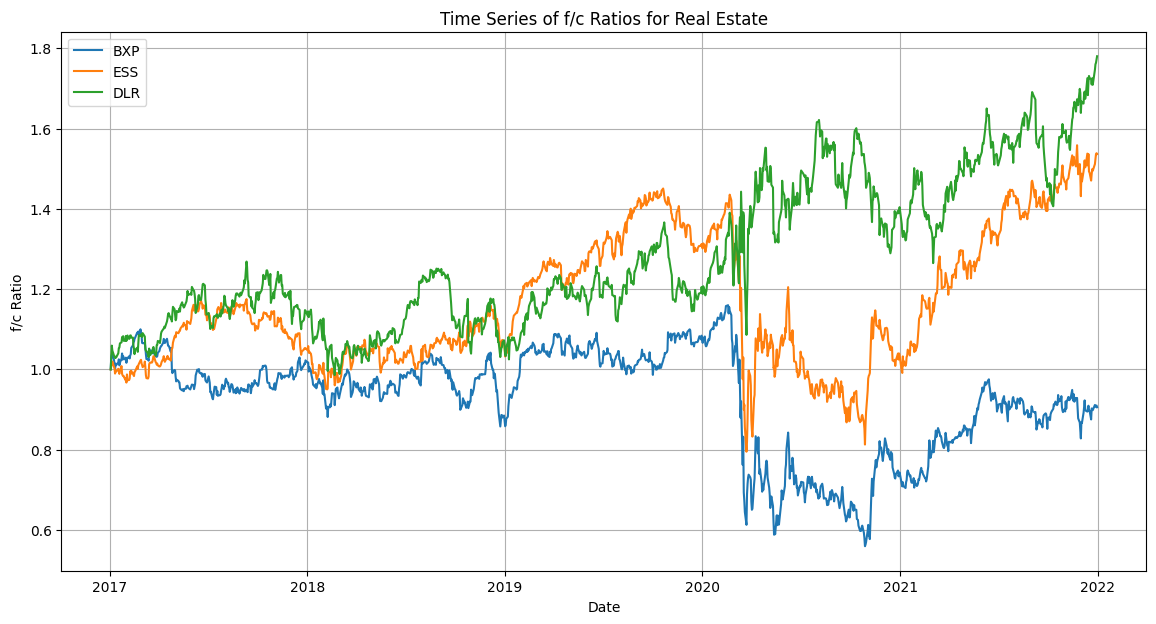

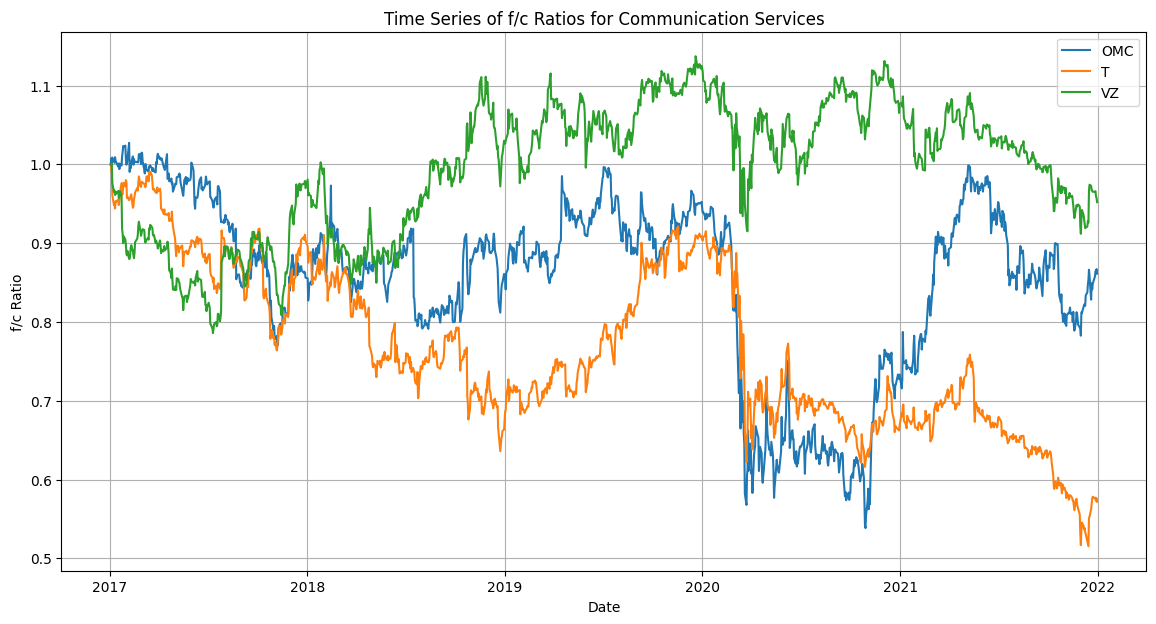

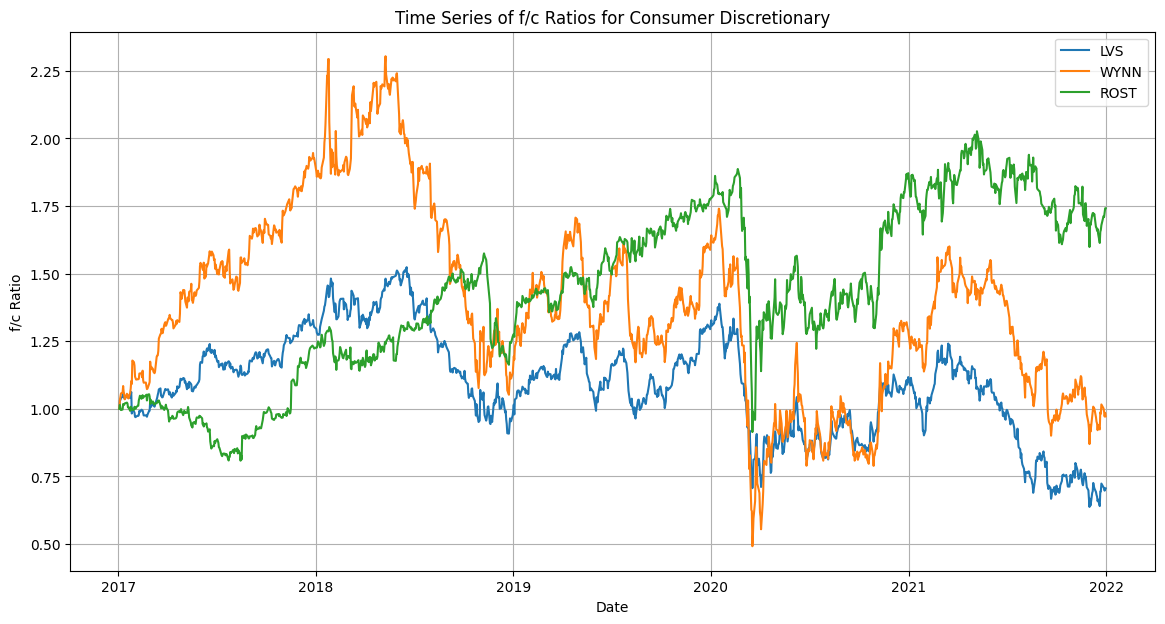

In [ ]:
# Loop through each sector and plot the f/c ratios
for sector, companies in sector_company.items():
    plt.figure(figsize=(14, 7))
    plt.title(f'Time Series of f/c Ratios for {sector}')
    # Looping through companies in each sector
    for company in companies:
        if company in stock_data.columns:
            # removing null values if any in selected company
            company_data = stock_data[[company]].dropna()
            if not company_data.empty:
                c = company_data.iloc[0][company]
                # creating a new column f/c
                company_data['f/c'] = company_data[company] / c
                plt.plot(company_data.index, company_data['f/c'], label=company)
    # Plotting graph with legend and labels
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('f/c Ratio')
    plt.grid(True)
    plt.show()


####Analysis on Time series plots

**Time series Visualization for Real Estate Sector Stocks (Graph 1) :** The three stocks, BXP, ESS, and DLR, present unique performance trends over the five-year span from January 2017 to December 2021, as seen in the f/c ratio time series.
The time series chart for the real estate sector displays varied performance among BXP, ESS, and DLR stocks from 2017 to 2021. BXP demonstrates a declining f/c ratio trend after 2020, suggesting underperformance relative to its initial value. ESS reveals resilience, with an overall growth in its f/c ratio despite temporary setbacks during early 2020. DLR stands out with a significant upward surge in its f/c ratio starting in 2020, suggesting a notably stronger financial metric improvement compared to its stock price. Each stock's trajectory provides insights into their financial health and market response during this period.



**Time series Visualization for Communication ServicesSector Stocks (Graph 2) :**The graph shows the f/c ratios for three stocks in the communication services sector: OMC, T, and VZ from 2017 to the end of 2021.Across all three stocks, there's a marked reaction around 2020, reflecting the potential impact of the pandemic on the communication services sector. Each stock responded differently to the conditions, with VZ showing a notable peak during this period, perhaps indicating a surge in demand or positive financial metrics relative to its stock price, which is common in communication services due to increased demand for connectivity in remote work and entertainment. In contrast, OMC and T showed declines, suggesting their financial metrics did not keep pace with their stock prices or that they faced more significant challenges during this period

**Time Series Visulization for Consumer Discretionary(Graph 3):**This graph displays the f/c ratios for three stocks within the consumer discretionary sector: LVS, WYNN, and ROST, from 2017 to the end of 2021.The consumer discretionary sector shows significant volatility in these stocks' f/c ratios, particularly impacted by the events of 2020, likely reflecting the pandemic's disruption to consumer spending patterns. ROST appears to have maintained a relative advantage over LVS and WYNN in terms of the predictive financial metrics.

**Performing Percentage Change on the data.**


In [ ]:
# create a new DataFrame pct_data for each ticker using pct_change as the return
pct_data = pd.DataFrame()
for i in TOP_3.columns:
  pct_data[i] = TOP_3[i].pct_change()
# drop the na records
pct_data.dropna(inplace=True)


In [ ]:
pct_data

,BXP,ESS,DLR,OMC,T,VZ,LVS,WYNN,ROST
Date,,,,,,,,,
2017-01-04,0.031766,0.007764,0.031703,0.007406,-0.005811,-0.001099,0.030939,0.032243,0.014327
2017-01-05,0.004801,0.007488,0.026632,-0.007468,-0.002806,0.002201,0.001819,0.012849,-0.012923
2017-01-06,-0.002275,0.004210,-0.011402,0.008817,-0.031184,-0.025256,0.007081,0.010827,-0.005785
2017-01-09,-0.009958,-0.012878,-0.011918,-0.004895,-0.012585,-0.010890,0.004327,0.003462,0.002144
2017-01-10,-0.011133,-0.002730,-0.004280,-0.001757,0.000245,0.001519,0.016155,0.022426,0.020168
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.014353,0.011206,0.021730,0.010528,-0.003619,0.000000,-0.018658,-0.014626,0.020062
2021-12-28,-0.005091,0.008975,0.007839,0.007951,0.001614,0.000759,-0.005809,-0.012788,-0.001869
2021-12-29,0.002342,0.007408,0.002288,0.000136,-0.007252,-0.006829,-0.012218,-0.017118,0.010253


In [ ]:
# here's the covariance matrix
df_cov = pct_data.cov()
df_cov

,BXP,ESS,DLR,OMC,T,VZ,LVS,WYNN,ROST
BXP,0.000397,0.000261,0.000127,0.000207,0.000136,0.000086,0.000222,0.000330,0.000234
ESS,0.000261,0.000306,0.000142,0.000147,0.000109,0.000078,0.000161,0.000238,0.000198
DLR,0.000127,0.000142,0.000298,0.000070,0.000080,0.000068,0.000058,0.000055,0.000084
OMC,0.000207,0.000147,0.000070,0.000340,0.000152,0.000088,0.000205,0.000280,0.000199
T,0.000136,0.000109,0.000080,0.000152,0.000229,0.000118,0.000122,0.000156,0.000127
VZ,0.000086,0.000078,0.000068,0.000088,0.000118,0.000143,0.000055,0.000057,0.000080
LVS,0.000222,0.000161,0.000058,0.000205,0.000122,0.000055,0.000586,0.000651,0.000233
WYNN,0.000330,0.000238,0.000055,0.000280,0.000156,0.000057,0.000651,0.001082,0.000347
ROST,0.000234,0.000198,0.000084,0.000199,0.000127,0.000080,0.000233,0.000347,0.000471


In [ ]:
Corr_matrix = pct_data.corr()
Corr_matrix

,BXP,ESS,DLR,OMC,T,VZ,LVS,WYNN,ROST
BXP,1.000000,0.749670,0.368836,0.563987,0.449810,0.359888,0.459556,0.503261,0.541948
ESS,0.749670,1.000000,0.468751,0.455920,0.410659,0.371421,0.381153,0.414302,0.522725
DLR,0.368836,0.468751,1.000000,0.221315,0.308114,0.329464,0.139650,0.096651,0.223745
OMC,0.563987,0.455920,0.221315,1.000000,0.543006,0.398757,0.459644,0.460867,0.495989
T,0.449810,0.410659,0.308114,0.543006,1.000000,0.654260,0.333068,0.313499,0.388086
VZ,0.359888,0.371421,0.329464,0.398757,0.654260,1.000000,0.190478,0.145189,0.307941
LVS,0.459556,0.381153,0.139650,0.459644,0.333068,0.190478,1.000000,0.818007,0.444215
WYNN,0.503261,0.414302,0.096651,0.460867,0.313499,0.145189,0.818007,1.000000,0.485647
ROST,0.541948,0.522725,0.223745,0.495989,0.388086,0.307941,0.444215,0.485647,1.000000


In [ ]:

# Average Value for Return for each of the Stocks
avg_return  = pct_data.mean()

print("Average return: ",avg_return)

# Standard Deviation for Return for each of the Stocks
Std_Dev_Return = (pct_data.std())  # Use .std() to get the sample standard deviation
print("Standard Deviation: ",Std_Dev_Return)

Average return:  BXP     0.000120
ESS     0.000496
DLR     0.000608
OMC     0.000051
T      -0.000329
VZ      0.000032
LVS     0.000017
WYNN    0.000519
ROST    0.000677
dtype: float64
Standard Deviation:  BXP     0.019933
ESS     0.017496
DLR     0.017266
OMC     0.018449
T       0.015125
VZ      0.011956
LVS     0.024208
WYNN    0.032895
ROST    0.021703
dtype: float64


##2- Optimization Model

###2.1 Defining the model and allocating the constraints

In [ ]:
from pyomo.environ import *
m = ConcreteModel()

# defining variables
# each one is a stock (Computer, Chemical, Power, Auto, Electronic)
m.BXP = Var(within=NonNegativeReals, bounds=(0,1))
m.ESS = Var(within=NonNegativeReals, bounds=(0,1))
m.DLR = Var(within=NonNegativeReals, bounds=(0,1))
m.OMC = Var(within=NonNegativeReals, bounds=(0,1))
m.T = Var(within=NonNegativeReals, bounds=(0,1))
m.VZ = Var(within=NonNegativeReals, bounds=(0,1))
m.LVS = Var(within=NonNegativeReals, bounds=(0,1))
m.WYNN = Var(within=NonNegativeReals, bounds=(0,1))
m.ROST = Var(within=NonNegativeReals, bounds=(0,1))



# Declaring Binary Decision variables

# Real Estate Sector ['BXP', 'ESS', 'DLR']
m.bBXP = Var(within=Binary, bounds=(0,1))
m.bESS = Var(within=Binary, bounds=(0,1))
m.bDLR= Var(within=Binary, bounds=(0,1))

# Communication Services ['OMC', 'T', 'VZ']
m.bOMC= Var(within=Binary, bounds=(0,1))
m.bT = Var(within=Binary, bounds=(0,1))
m.bVZ = Var(within=Binary, bounds=(0,1))

#Consumer Discretionary  sector ['LVS', 'WYNN', 'ROST']
m.bLVS = Var(within=Binary, bounds=(0,1))
m.bWYNN = Var(within=Binary, bounds=(0,1))
m.bROST = Var(within=Binary, bounds=(0,1))




○	For each selected stock, the minimum allocation must be at least 2%; otherwise, the allocation must be equal to zero (-3 pts otherwise)
○	Your model must select at least one stock per sector (-3 pts otherwise)
○	You should consider at least 100 risk levels (-3 pts)
○	At least one risk level tested by your code must be discarded for being too small and leading to an infeasible problem (-3 pts).
○	You should not set a lower bound on the expected returns (-5 pts if you add such a constraint to your model—be careful with copy-and-paste!).
○	You should run the optimization model only once per risk level, i.e., your notebook should only have the code block that removes infeasible solutions  (-3 pts if the optimization model is unnecessarily executed for the same risk level more than once, e.g., without removing infeasible solutions—be careful with copy-and-paste!).
○	To train your model, you should use daily data from January 1, 2017, to December 31, 2021 (-3 points if an incorrect period is used).


#### Declare Objective

In [ ]:
# Declare objective
m.objective = Objective(expr =
                        m.bBXP*m.BXP*avg_return[0] +
                        m.bESS*m.ESS*avg_return[1] +
                        m.bDLR*m.DLR*avg_return[2] +
                        m.bOMC*m.OMC*avg_return[3] +
                        m.bT*m.T*avg_return[4] +
                        m.bVZ*m.VZ*avg_return[5] +
                        m.bLVS*m.LVS*avg_return[6] +
                        m.bWYNN*m.WYNN*avg_return[7] +
                        m.bROST*m.ROST*avg_return[8],
                        sense=maximize)

#### Declare all the required constraints

In [ ]:
# 1. Constraints: Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.BXP +
                        m.ESS +
                        m.DLR +
                        m.OMC +
                        m.T+
                        m.VZ +
                        m.LVS +
                        m.WYNN+
                        m.ROST == 1)

In [ ]:
# 2 Constraints: Minimum allocation of 2% for each stock else allocating value of stocks to zero
m.min_allocation_constraint = ConstraintList()
selected_stocks = ['BXP', 'ESS', 'DLR', 'OMC', 'T', 'VZ', 'LVS', 'WYNN', 'ROST']
for stock in selected_stocks:
    m.min_allocation_constraint.add(
        getattr(m, stock) >= 0.02 * getattr(m, 'b' + stock)
    )

In [ ]:
# 3 Constrainsts: Choose 1 Stock Per Sector

m.proportion_1  = Constraint(expr = m.bBXP + m.bESS + m.bDLR ==1)
m.proportion_2 = Constraint(expr = m.bOMC + m.T + m.bVZ ==1)
m.proportion_3 = Constraint(expr = m.bLVS + m.bWYNN + m.bROST ==1)

In [ ]:
# Printing total no of constraints and objectives associated to the model
m.pprint()

18 Var Declarations
    BXP : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    DLR : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    ESS : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    LVS : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    OMC : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    ROST : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
 

####Calculate Risk

In [ ]:
# Calculate Risk
def calc_risk(m):
    variables = [m.BXP, m.ESS, m.DLR, m.OMC, m.T, m.VZ, m.LVS, m.WYNN, m.ROST]
    tickers = ["BXP", "ESS", "DLR", "OMC", "T", "VZ", "LVS", "WYNN", "ROST"]
    risk_exp = 0
    for i in range(len(variables)):
      for j in range(len(variables)):
        risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
    return risk_exp

# We are going to use this expression to compute the risk
m.risk_expression = Expression(rule=calc_risk)

In [ ]:
# Defining max risk and printing
max_risk = 0.0006
# Sequence of risk levels
risk_limits = np.arange(0.00001, max_risk, 0.000005)

print( risk_limits)

[1.00e-05 1.50e-05 2.00e-05 2.50e-05 3.00e-05 3.50e-05 4.00e-05 4.50e-05
 5.00e-05 5.50e-05 6.00e-05 6.50e-05 7.00e-05 7.50e-05 8.00e-05 8.50e-05
 9.00e-05 9.50e-05 1.00e-04 1.05e-04 1.10e-04 1.15e-04 1.20e-04 1.25e-04
 1.30e-04 1.35e-04 1.40e-04 1.45e-04 1.50e-04 1.55e-04 1.60e-04 1.65e-04
 1.70e-04 1.75e-04 1.80e-04 1.85e-04 1.90e-04 1.95e-04 2.00e-04 2.05e-04
 2.10e-04 2.15e-04 2.20e-04 2.25e-04 2.30e-04 2.35e-04 2.40e-04 2.45e-04
 2.50e-04 2.55e-04 2.60e-04 2.65e-04 2.70e-04 2.75e-04 2.80e-04 2.85e-04
 2.90e-04 2.95e-04 3.00e-04 3.05e-04 3.10e-04 3.15e-04 3.20e-04 3.25e-04
 3.30e-04 3.35e-04 3.40e-04 3.45e-04 3.50e-04 3.55e-04 3.60e-04 3.65e-04
 3.70e-04 3.75e-04 3.80e-04 3.85e-04 3.90e-04 3.95e-04 4.00e-04 4.05e-04
 4.10e-04 4.15e-04 4.20e-04 4.25e-04 4.30e-04 4.35e-04 4.40e-04 4.45e-04
 4.50e-04 4.55e-04 4.60e-04 4.65e-04 4.70e-04 4.75e-04 4.80e-04 4.85e-04
 4.90e-04 4.95e-04 5.00e-04 5.05e-04 5.10e-04 5.15e-04 5.20e-04 5.25e-04
 5.30e-04 5.35e-04 5.40e-04 5.45e-04 5.50e-04 5.55e

In [ ]:
#printing the length of the risk limits
print(len(risk_limits))

118


####Run the model

In [ ]:
# Initialize dictionaries to store results
param_analysis = {} # key=risk, value = stock allocations
returns = {} # key=risk, value = return
infeasible_risks = []  # store infeasible risk values
for r in risk_limits:

    # Remove constraint to avoid error messages
    if hasattr(m, 'total_risk'):
        m.del_component(m.total_risk)
    # Set the total risk constraint
    m.total_risk = Constraint(expr=m.risk_expression <= r)
    # Sloving MPT model with Bonmin
    result = SolverFactory('bonmin', executable='/content/bin/bonmin').solve(m)

    if result is None or result.solver.termination_condition == TerminationCondition.infeasible:
        infeasible_risks.append(r)  # Store infeasible risk values and continue to the next iteration
        continue

    # store our allocation proportions
    param_analysis[r] = [m.BXP(), m.ESS(), m.DLR(), m.OMC(), m.T(), m.VZ(), m.LVS(), m.WYNN(), m.ROST()]
    # store our returns
    # Evaluate the expressions to obtain numerical values
    returns[r] = (value(m.BXP) * avg_return[0] +
                  value(m.ESS) * avg_return[1] +
                  value(m.DLR) * avg_return[2] +
                  value(m.OMC) * avg_return[3] +
                  value(m.T) * avg_return[4] +
                  value(m.VZ )* avg_return[5] +
                  value(m.LVS) * avg_return[6] +
                  value(m.WYNN )* avg_return[7] +
                 value( m.ROST) * avg_return[8])


  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\

In [ ]:
# Printing all infeasible solutions
infeasible_risks

[1e-05,
 1.5000000000000002e-05,
 2.0000000000000005e-05,
 2.5000000000000005e-05,
 3.0000000000000004e-05,
 3.5000000000000004e-05,
 4.000000000000001e-05,
 4.500000000000001e-05,
 5.000000000000001e-05,
 5.500000000000001e-05,
 6.000000000000001e-05,
 6.500000000000002e-05,
 7.000000000000002e-05,
 7.500000000000002e-05,
 8.000000000000002e-05,
 8.500000000000002e-05,
 9.000000000000002e-05,
 9.500000000000002e-05,
 0.00010000000000000002,
 0.00010500000000000002,
 0.00011000000000000002]

####Check Feasible Solutions

In [ ]:
param_analysis

{0.00011500000000000003: [6.192265733957266e-06,
  0.016675479340292378,
  0.22395197245004175,
  0.04951908458596824,
  1.8169817193881718e-10,
  0.5822126035712875,
  0.06890466323152362,
  3.723092684459036e-06,
  0.05872628128077004],
 0.00012000000000000003: [1.0297070985871907e-07,
  2.0056337140214085e-07,
  0.28857265641316787,
  0.016926084901337485,
  9.448205304774066e-11,
  0.5211071641808177,
  0.048735990895066375,
  1.0038196446571796e-07,
  0.1246576995990827],
 0.00012500000000000003: [1.7120165427582683e-06,
  2.418187975550717e-06,
  0.3227084763628466,
  5.521243433053098e-05,
  0.0,
  0.48207896862276517,
  0.03527185654187292,
  2.0489164470395514e-06,
  0.15987930729610064],
 0.00013000000000000004: [1.5923513189970537e-05,
  2.0195404257794122e-05,
  0.35031370079414276,
  0.00010888494060495369,
  6.05389473792856e-11,
  0.44293563410729875,
  0.020838642274463533,
  2.1767981790949727e-05,
  0.18574525092371236],
 0.00013500000000000003: [1.2594180988114708e-0

###**2.2 Optimal Stock Allocation**

●	(3 pts) Show how your allocation into different stocks will vary for different risk levels.
○	The plot must show the efficient frontier reaching the plateau (-2 pts)
○	The plateau should not be more than 25% of the plot (-2 pts)
○	The plot should not contain infeasible allocations (-2 pts)
○	The plot must have a legend (-2 pts)
○	The plot must show the results of at least 80% of the risk levels (-2 pts)


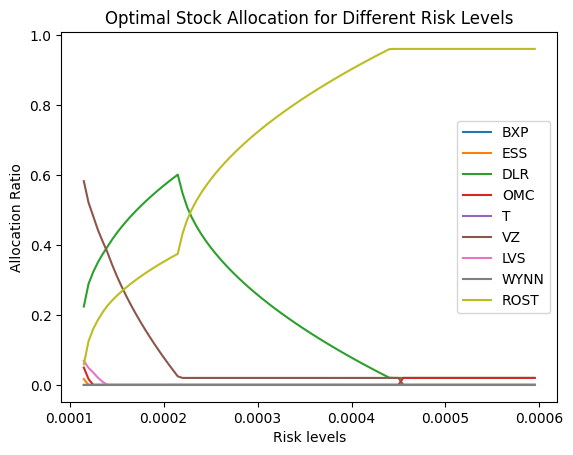

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = [ 'BXP', 'ESS', 'DLR', 'OMC', 'T', 'VZ', 'LVS', 'WYNN', 'ROST']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel("Risk levels")
plt.ylabel("Allocation Ratio")
plt.show()

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[0.00011500000000000003, 0.00012000000000000003, 0.00012500000000000003, 0.00013000000000000004, 0.00013500000000000003, 0.00014000000000000004, 0.00014500000000000003, 0.00015000000000000004, 0.00015500000000000003, 0.00016000000000000004, 0.00016500000000000003, 0.00017000000000000004, 0.00017500000000000005, 0.00018000000000000004, 0.00018500000000000005, 0.00019000000000000004, 0.00019500000000000005, 0.00020000000000000004, 0.00020500000000000005, 0.00021000000000000004, 0.00021500000000000005, 0.00022000000000000006, 0.00022500000000000005, 0.00023000000000000006, 0.00023500000000000005, 0.00024000000000000006, 0.00024500000000000005, 0.00025000000000000006, 0.00025500000000000007, 0.0002600000000000001, 0.0002650000000000001, 0.0002700000000000001, 0.00027500000000000007, 0.0002800000000000001, 0.0002850000000000001, 0.0002900000000000001, 0.0002950000000000001, 0.0003000000000000001, 0.0003050000000000001, 0.0003100000000000001, 0.0003150000000000001, 0.0003200000000000001, 0.0

###**2.3 Efficient Frontier**

●	(3 pts) Show the shape of the efficient frontier for different risk levels.
○	The plot must show the efficient frontier reaching the plateau (-2 pts)
○	The plateau should not be more than 25% of the plot (-2 pts)
○	The plot should not contain infeasible allocations (-2 pts)
○	The plot must have a legend (-2 pts)
○	The plot must show the results of at least 80% of the risk levels (-2 pts)


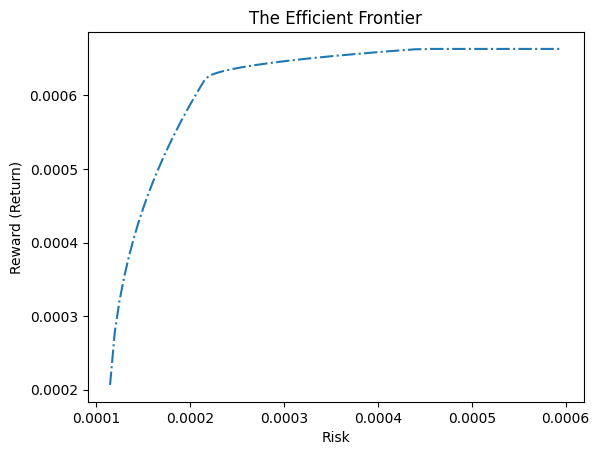

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')

plt.show()

###**2.4 Portfolio Allocation**

●	Select one of the portfolio allocations returned by the optimization model containing at least three stocks that are assigned at least 10% of the budget each (-3 points otherwise). If your first MPT formulation does not have such a solution with this characteristic, you must change the model so that such a solution is produced (i.e., change your model in a way that each selected stock uses at least 10% of the budget); you must also show the plots for this new model (-2 pts for each plot that is missing). Otherwise, if your original model already has a solution containing at least three stocks assigned at least 10% of the budget, you should not change and run the model again (-5 pts if a model is unnecessarily created, executed, and presented).
●	The set of stocks and the allocation must be extracted from the MPT model (-3 points if another allocation is used; minor roundings are acceptable). Very small allocations (i.e., inferior to 1%) should be rounded down to zero, and the allocation must sum up to exactly 100% (-3 pts if allocation does not sum up to 100%). This portfolio allocation will be used in the next items.


#### Select Stocks with atleast 10% allocation

Our original model already has a solution containing 3 stocks with atleast 10% percent of budget

In [ ]:
import pandas as pd

# Assuming param_analysis is a pandas DataFrame with a Float64Index
# and you want to find the value closest to 0.0009

# If param_analysis is a DataFrame with risk levels as the index, you can convert it to a Series
risk_series = pd.Series(param_analysis.index)

# Finding the index nearest to 0.0009
# Compute the absolute difference and find the index of the minimum value
closest_index = (risk_series - 0.000190).abs().idxmin()

# Now you can access the row in param_analysis using iloc
closest_values = param_analysis.iloc[closest_index]

def saferound(value, places):
    """
    Rounds a number to a given precision in decimal digits, avoiding issues with floating-point representation.

    :param value: The number to round.
    :param places: The number of decimal places to round to.
    :return: The rounded number as a float.
    """
    format_string = '{0:.' + str(places) + 'f}'
    return float(format_string.format(value))

# Assuming closest_values is a pandas Series with numerical values
rounded_values = closest_values.apply(lambda x: saferound(x, places=3))

# Create a new Series with the rounded values
portfolio = pd.Series(rounded_values, index=closest_values.index)

print(portfolio)



BXP     0.000
ESS     0.000
DLR     0.547
OMC     0.000
T       0.000
VZ      0.117
LVS     0.000
WYNN    0.000
ROST    0.336
Name: 0.00019000000000000004, dtype: float64


In [ ]:
# Assuming param_analysis is a DataFrame with a Float64Index
# and you want to find the value closest to 0.0009

# Use get_indexer method as suggested by the warning
closest_idx_pos = param_analysis.index.get_indexer([0.000190], method='nearest')[0]
closest_index = param_analysis.index[closest_idx_pos]

# Assuming saferound is defined as provided previously
portfolio = pd.Series({ticker: saferound(value, places=3) for ticker, value in param_analysis.loc[closest_index].items()})

# Now portfolio contains the rounded allocations for the risk level closest to 0.0009
print(portfolio)



BXP     0.000
ESS     0.000
DLR     0.547
OMC     0.000
T       0.000
VZ      0.117
LVS     0.000
WYNN    0.000
ROST    0.336
dtype: float64


#### Check portfolio allocation summing to 100%

In [ ]:
portfolio.sum()

1.0

## **3- Buy-and-hold Strategy**


* Let’s see how you would have applied the following investment strategies in 2022. You can
suppose you have 100,000/- to invest. You should use the portfolio allocation selected by the MPT model
* (-3 points if a different allocation is used). Fractional shares are okay, i.e., if the
stock costs $100, but your allocation restricts the purchase to $50, you will buy 0.5 shares of
this stock (this is not a simplification; this happens in practice!). Your solution will not be
evaluated based on the returns of your portfolio, i.e., if you lose money, it’s OK! If there is
no data for the first day of a month (e.g., holiday, weekend), please use data from the first
trading day of the respective month (i.e., the first day in that month for which you have
data).
* (10 pts) Buy-and-Hold strategy for the MPT portfolio: Assume that you are buying
stocks using the MPT allocation on the first trading day of 2022 and selling all your
shares on the last trading day of 2022. Create a table that shows
** a) the amount of
money invested in each stock of your portfolio,
** b) the aggregate value of the entire
portfolio,
** c) the percentual return of each stock (i.e., the same 𝑓/𝑐 values you used
above), and
** d) the percentual return of the entire portfolio on the last trading day of
each month from Jan 31st, 2022 (when you would have done your allocation), February
28th, 2022 …, through December 31st, 2022. You should only show the results for
stocks with nonzero allocation (-2 points otherwise).
* (5 pts) Buy-and-Hold strategy for the S&P 500 index (^GSPC): Assume for this item
that you are investing all your budget in the S&P 500 index (denoted by ^GSPC), also
buying in the first trading day of 2022 and selling everything in the last trading day of
2022
* Create a table that shows a) the aggregate value of your investment and b) the
percentual return on the last day of each month from Jan 31st, 2022 (when you would
have done your allocation), February 28th, 2022 …, through December 31st, 2022.
* (5 pts) Show the performance of each of the two strategies above in a single plot.
Compare and analyze the results obtained by these two strategies.
** Your plot must have a legend (-2 pts)
** Your plot must have labels (-2 pts)

###3.1 Buy-and-Hold strategy for the MPT portfolio

In [ ]:
from IPython.display import display

# Initialize your investment amount and portfolio allocations from MPT model
investment_amount = 100000
#MPT result
mpt_portfolio_allocations = { 'BXP':0.00, 'ESS':0.00, 'DLR':0.547, 'OMC':0.00, 'VZ':0.117, 'LVS':0.00, 'WYNN':0.00, 'ROST':0.336}
# Convert dictionary to DataFrame
df_weights = pd.DataFrame(list(mpt_portfolio_allocations.items()), columns=['Name of Stock', 'Allocation'])
portfolio=df_weights
stock_symbol = ['BXP', 'ESS', 'DLR','OMC','VZ', 'LVS', 'WYNN','ROST']

# Retrieving historical daily price data for each stock in the portfolio for 2022
retrieved_portfolio_stock_prices = {ticker: si.get_data(ticker, start_date='01/01/2022', end_date='12/31/2022', interval='1d') for ticker in stock_symbol}

In [ ]:
# Define function to retrieve stock prices for 2022
def get_stock_prices(tickers, start_date, end_date):
    prices = {}
    for ticker in tickers:
        prices[ticker] = si.get_data(ticker, start_date=start_date, end_date=end_date)['adjclose']
    return prices


### 3.2 Buy-and-Hold strategy for the S&P 500 index (^GSPC)

In [ ]:
# Retrieve stock prices for 2022 for S&P 500 index and selected stocks
sp500_prices = get_stock_prices(['^GSPC'], '2022-01-01', '2022-12-31')
retrieved_stock_prices = get_stock_prices(stock_symbol, '2022-01-01', '2022-12-31')

In [ ]:
# Aggregating adjusted close prices from each stock in the portfolio
portfolio_data = pd.DataFrame()
for i in stock_symbol:
    portfolio_data[i] = pd.DataFrame(retrieved_portfolio_stock_prices[i]['adjclose'])
display(portfolio_data.head())

,BXP,ESS,DLR,OMC,VZ,LVS,WYNN,ROST
2022-01-03,105.454575,324.725464,159.983109,68.289551,44.822590,38.404591,86.880432,110.071037
2022-01-04,108.962692,327.267426,154.500793,69.795998,45.702972,38.216770,86.603271,110.071037
2022-01-05,107.494377,320.568451,148.826584,70.027046,46.173073,36.546146,83.396118,106.666573
2022-01-06,109.727615,320.219727,146.926071,71.884712,45.950840,37.396286,83.782158,106.452576
2022-01-07,110.457375,315.961731,147.163635,72.448463,46.919685,37.465485,83.693062,102.124046


In [ ]:

# Creating a list of initial investment amounts for each portfolio component, scaled by 100,000
investment = [investment_amount * weight for weight in mpt_portfolio_allocations.values()]

# Calculating the number of shares bought for each stock
num_shares = [inv / price for inv, price in zip(investment, portfolio_data.iloc[0])]

# Calculating the value of each investment over time
investment_values = portfolio_data * num_shares

# Calculating the total portfolio value over time
portfolio_values = investment_values.sum(axis=1)

# Calculating the monthly returns of each stock and the portfolio
monthly_returns = portfolio_values.pct_change().dropna()
monthly_stock_returns = portfolio_data.pct_change().dropna()

display(portfolio_data.head(5))

# Displaying the monthly returns
display(monthly_returns.head(5))

# Creating a table for the portfolio investments and returns
portfolio_table = pd.concat([investment_values, portfolio_values, monthly_stock_returns, monthly_returns], axis=1)
portfolio_table.columns = [f"Investment in {ticker}" for ticker in stock_symbol] + ['Portfolio Value'] + [f"{ticker} Return" for ticker in stock_symbol] + ['Portfolio Return']
closing_prices_monthly = portfolio_table.resample('M').last().rename_axis('Date')

# Displaying the portfolio table
#print(portfolio_table.head())
display(closing_prices_monthly.head(12))


,BXP,ESS,DLR,OMC,VZ,LVS,WYNN,ROST
2022-01-03,105.454575,324.725464,159.983109,68.289551,44.822590,38.404591,86.880432,110.071037
2022-01-04,108.962692,327.267426,154.500793,69.795998,45.702972,38.216770,86.603271,110.071037
2022-01-05,107.494377,320.568451,148.826584,70.027046,46.173073,36.546146,83.396118,106.666573
2022-01-06,109.727615,320.219727,146.926071,71.884712,45.950840,37.396286,83.782158,106.452576
2022-01-07,110.457375,315.961731,147.163635,72.448463,46.919685,37.465485,83.693062,102.124046


2022-01-04   -0.016447
2022-01-05   -0.029044
2022-01-06   -0.008096
2022-01-07   -0.010422
2022-01-10   -0.012880
dtype: float64

,Investment in BXP,Investment in ESS,Investment in DLR,Investment in OMC,Investment in VZ,Investment in LVS,Investment in WYNN,Investment in ROST,Portfolio Value,BXP Return,ESS Return,DLR Return,OMC Return,VZ Return,LVS Return,WYNN Return,ROST Return,Portfolio Return
Date,,,,,,,,,,,,,,,,,,
2022-01-31,0.0,0.0,46621.051283,0.0,12019.345015,0.0,0.0,29024.390002,87664.786300,-0.010768,0.001084,0.002351,0.009782,0.006238,0.016006,0.015690,0.020675,0.008882
2022-02-28,0.0,0.0,42150.460402,0.0,12118.696664,0.0,0.0,27135.947459,81405.104525,-0.009315,-0.022950,-0.021610,-0.004391,-0.008315,-0.037287,-0.014242,-0.014451,-0.017269
2022-03-31,0.0,0.0,44701.787269,0.0,11502.262575,0.0,0.0,26955.019934,83159.069779,-0.015742,-0.009291,-0.016371,-0.016910,-0.012982,-0.019672,-0.017617,-0.023216,-0.018135
2022-04-30,0.0,0.0,46063.645835,0.0,10581.850835,0.0,0.0,29729.189198,86374.685868,-0.048005,-0.045899,-0.035512,-0.032287,-0.043389,-0.007007,-0.003676,-0.042239,-0.038805
2022-05-31,0.0,0.0,44005.094370,0.0,11722.314690,0.0,0.0,25334.026966,81061.436026,-0.013312,-0.016765,-0.013568,-0.005200,-0.002140,0.024263,0.012872,-0.026228,-0.015937
2022-06-30,0.0,0.0,41324.721314,0.0,11598.896832,0.0,0.0,21005.665411,73929.283557,-0.011443,-0.003202,0.019074,0.004580,-0.003730,-0.000595,-0.017586,-0.022002,0.003495
2022-07-31,0.0,0.0,42158.659152,0.0,10689.523942,0.0,0.0,24304.714772,77152.897865,0.011989,0.006074,-0.032717,0.002728,0.014050,-0.021547,-0.002671,-0.001720,-0.016818
2022-08-31,0.0,0.0,39351.266771,0.0,9675.881408,0.0,0.0,25803.196746,74830.344925,-0.004761,-0.004768,-0.001454,-0.016032,-0.016929,0.026739,0.006311,-0.000695,-0.003222
2022-09-30,0.0,0.0,31892.647539,0.0,8787.210098,0.0,0.0,25293.587439,65973.445076,0.003883,0.014958,0.023424,-0.005830,-0.017339,-0.026213,-0.020513,0.002856,0.009903


In [ ]:
import yfinance as yf
# Retrieving historical daily price data for the S&P 500 index for 2022
sp500_data = yf.download('^GSPC', start='2022-01-01', end='2022-12-31')['Adj Close']
sp500_data = sp500_data.resample('M').last().rename_axis('Date')

# Calculating the number of shares bought for the S&P 500 index
sp500_shares = investment_amount / sp500_data.iloc[0]

# Calculating the value of the S&P 500 investment over time
sp500_values = sp500_data * sp500_shares

# Calculating the monthly returns of the S&P 500 index
sp500_monthly_returns = sp500_values.pct_change().dropna()
sp500_monthly_returns = sp500_monthly_returns.resample('M').last().rename_axis('Date')

# Displaying the first few rows of the S&P 500 data
display(sp500_values.head(12))

# Displaying the monthly returns of the S&P 500 index
display(sp500_monthly_returns.head(12))


[*********************100%%**********************]  1 of 1 completed


Date
2022-01-31    100000.000000
2022-02-28     96863.950805
2022-03-31    100329.092850
2022-04-30     91504.475745
2022-05-31     91509.341743
2022-06-30     83829.877790
2022-07-31     91468.153773
2022-08-31     87586.233594
2022-09-30     79406.058449
2022-10-31     85747.697356
2022-11-30     90356.884187
2022-12-31     85028.405534
Freq: M, Name: Adj Close, dtype: float64

Date
2022-02-28   -0.031360
2022-03-31    0.035773
2022-04-30   -0.087957
2022-05-31    0.000053
2022-06-30   -0.083920
2022-07-31    0.091116
2022-08-31   -0.042440
2022-09-30   -0.093396
2022-10-31    0.079863
2022-11-30    0.053753
2022-12-31   -0.058971
Freq: M, Name: Adj Close, dtype: float64

In [ ]:
def buy_and_hold_strategy(prices, allocations, investment_amount):
    # Calculate the amount invested in each stock
    amounts = {ticker: investment_amount * allocation for ticker, allocation in allocations.items()}
    # Calculate the aggregate value over time
    portfolio_values = pd.DataFrame(index=prices[list(prices.keys())[0]].index)
    for ticker, amount in amounts.items():
        portfolio_values[ticker] = prices[ticker] / prices[ticker][0] * amount
    portfolio_values['Total'] = portfolio_values.sum(axis=1)
    return portfolio_values

In [ ]:
# Compute the investment value over time using the Buy-and-Hold strategy for MPT portfolio
mpt_buy_and_hold_values = buy_and_hold_strategy(retrieved_stock_prices, mpt_portfolio_allocations, investment_amount)

# Compute the investment value over time using the Buy-and-Hold strategy for S&P 500 index
sp500_buy_and_hold_values = buy_and_hold_strategy({'^GSPC': sp500_prices['^GSPC']}, {'^GSPC': 1}, investment_amount)

### 3.3 Performance of both strategies in a single plot

In [ ]:
# Prepare data for plotting
dates = mpt_buy_and_hold_values.index
values_dict = {
    'MPT Buy-and-Hold': mpt_buy_and_hold_values['Total'],
    'S&P 500 Buy-and-Hold': sp500_buy_and_hold_values['Total']
}

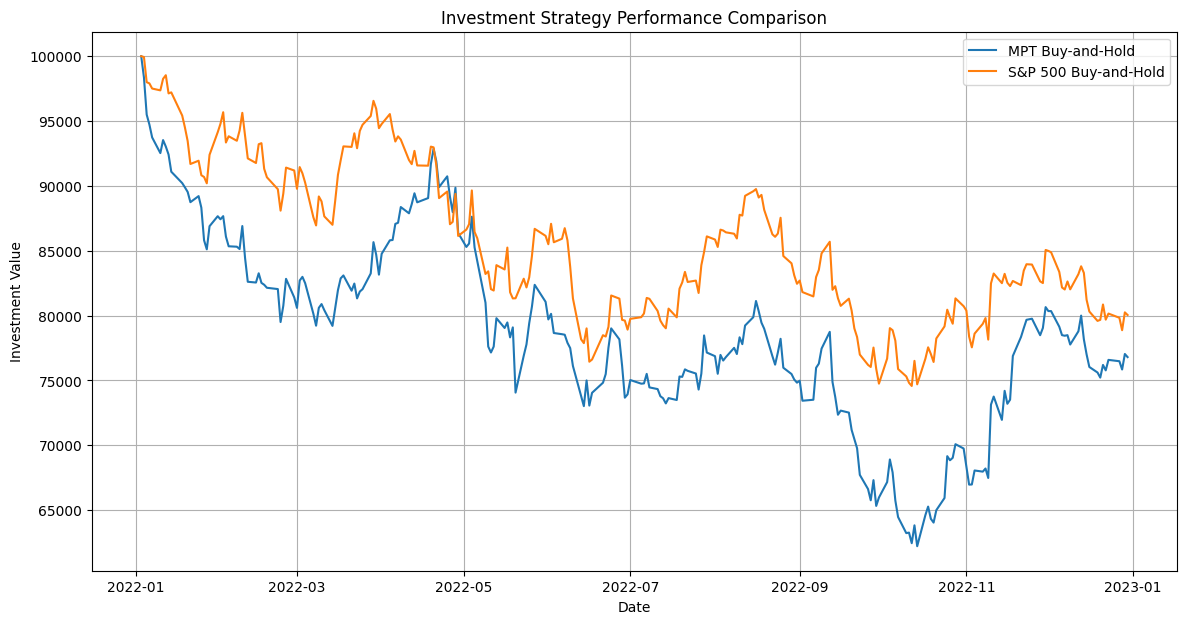

In [ ]:
# Plot the performance of both strategies in a single plot
plt.figure(figsize=(14, 7))
for strategy, values in values_dict.items():
    plt.plot(dates, values, label=strategy)

#Define labels
plt.xlabel('Date')
plt.ylabel('Investment Value')
plt.title('Investment Strategy Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Table of MPT and  Buy-and-Hold strategy for the S&P 500 investment for last day of each month from Jan 1,2022 to Dec 1 2022

df_table = pd.concat([mpt_buy_and_hold_values['Total'], sp500_buy_and_hold_values['Total']], axis=1).resample('M').last()

df_table.columns = ['Buy & hold - MPT', 'Buy & hold - S&P500']

print(df_table)#Display Table


            Buy & hold - MPT  Buy & hold - S&P500
2022-01-31      87664.800100         94141.421134
2022-02-28      81405.108380         91189.099854
2022-03-31      83159.084502         94451.233820
2022-04-30      86374.694560         86143.613867
2022-05-31      81061.443985         86148.194787
2022-06-30      73929.287490         78918.638286
2022-07-31      77152.909146         86109.419847
2022-08-31      74830.352638         82454.925023
2022-09-30      65973.449299         74753.991890
2022-10-31      69752.123920         80724.100880
2022-11-30      80654.570356         85063.254866
2022-12-31      76802.333970         80046.949337


####Performance Analysis

In 2022, both the MPT and S&P 500 Buy-and-Hold investment strategies declined in value, with the S&P 500 generally retaining a higher value each month compared to the MPT strategy. The MPT strategy exhibited more pronounced fluctuations and a steeper overall decline, ending the year at approximately $76,802.

In contrast, the S&P 500 strategy was slightly less volatile, starting at around $94,141. These trends suggest that while the MPT strategy might aim for higher returns through diversification, it also faced greater risk and sensitivity to adverse market conditions. The S&P 500's more consistent performance could be more appealing for those seeking stability during market uncertainties.

## **4- Monte Carlo Analysis**

(10 pts) You must simulate the annual performance of your model 1000 times (i.e., you will sample daily returns for all stocks for one year 1000 times). (-3 pts if fewer simulations are used)
You must sample the daily return of each stock 252 times (one for each trading day in 2022). (-3 pts otherwise)	You must assume that the daily return of each stock is stationary and follows a normal distribution parameterized by the same average and standard deviation you used when training the MPT model (i.e., based on daily data from 2017-2021). (-3 pts if wrong parameters are used). So, for each stock and each simulation, you will sample 252 values from a normal distribution. (-3 pts otherwise)
For the next item, you must keep track of the performance (percentual return f/c) of each stock composing your portfolio and the performance (percentual return f/c) of the entire portfolio using the MPT allocation (-3 pts if the wrong allocation is used).
(10 pts) You must present a density plot showing the expected return of the portfolio. Moreover, you must report the probability that each stock in your portfolio will lose money. Finally, you must report the probability that your portfolio will lose money; your portfolio must follow the MPT allocation (-3 pts if the wrong allocation is used). You must present the results in a text block instead of leaving it as the output of some code block (-2 pts otherwise).
Your plots must have a legend (-2 pts each)
Your plots must have labels (-2 pts each)


In [ ]:


# Example mean and std deviation for stocks (these should be replaced with actual values from your data)
mean_returns = {'DLR':0.000608,'VZ':0.000032,'ROST':0.000677}  # daily mean returns
std_devs = {'DLR':0.017266 ,'VZ':0.011956 , 'ROST':0.021703}  # daily standard deviations

# Number of trading days and simulations
num_days = 252
num_simulations = 1000

# Simulating returns for annual performance
# Normal distrubition parameterized by same average and standard deviation used in MPT model(2017-2021)
simulated_returns = {stock: np.random.normal(loc=mean, scale=std_devs[stock], size=(num_simulations, num_days))
                     for stock, mean in mean_returns.items()}




In [ ]:
# MPT allocations for each stock
allocations = {'DLR':0.547 ,'VZ':0.117 , 'ROST':0.336}

# Calculate portfolio returns for each simulation
portfolio_returns = np.sum([simulated_returns[stock] * allocations[stock] for stock in simulated_returns], axis=0)
annual_returns = np.sum(portfolio_returns, axis=1)  # Sum over days to get annual returns


#### 4.1 Density Plot

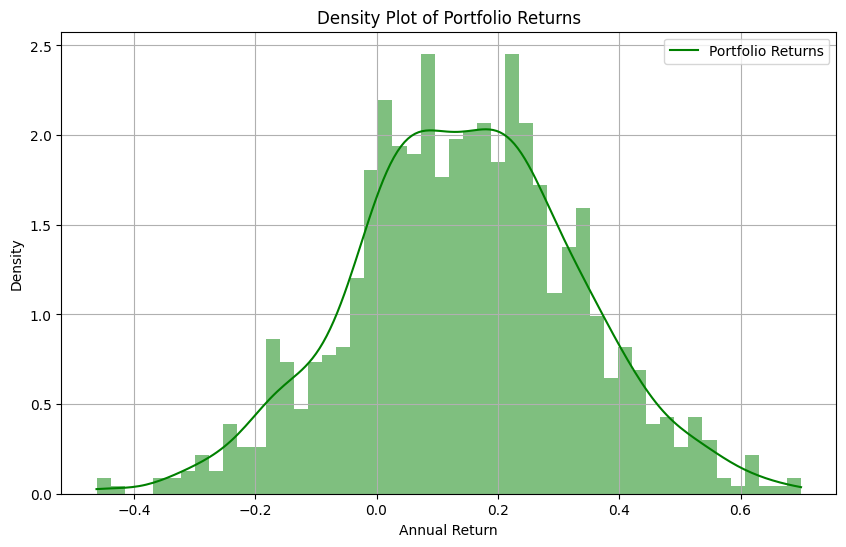

Probability of loss for each stock:
DLR: 48.52%
VZ: 49.91%
ROST: 48.87%
Probability of portfolio loss: 20.40%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Probability of losing money
loss_probabilities = {stock: np.mean(simulated_returns[stock].flatten() < 0) for stock in simulated_returns}
portfolio_loss_probability = np.mean(annual_returns < 0)

# Creating the density plot
plt.figure(figsize=(10, 6))
#plt.hist(annual_returns, bins=50, alpha=0.75, density=True)
sns.histplot(annual_returns, bins=50, kde=True, color='green', stat='density',linewidth=0)
plt.title('Density Plot of Portfolio Returns')
plt.xlabel('Annual Return')
plt.ylabel('Density')
plt.legend(['Portfolio Returns'])
plt.grid(True)
plt.show()

# Display probabilities of loss

print("Probability of loss for each stock:")
for stock, probability in loss_probabilities.items():
    print(f"{stock}: {probability:.2%}")
print(f"Probability of portfolio loss: {portfolio_loss_probability:.2%}")


In [ ]:

# Assuming loss_probabilities is a dictionary with your stocks
# and portfolio_loss_probability is a single value
print("Monte Carlo Analysis Results:")
print("\nProbability of Losing Money (Each Stock):\n")
stock_loss_df = pd.DataFrame(list(loss_probabilities.items()), columns=['Stock', 'Probability of Loss'])
print(stock_loss_df)

Monte Carlo Analysis Results:

Probability of Losing Money (Each Stock):

  Stock  Probability of Loss
0   DLR             0.485183
1    VZ             0.499115
2  ROST             0.488655




####4.2 Monte Carlo Analysis Results

Probability of Losing Money (Each Stock):

| Stock | Probability of Loss |
|-------|---------------------|
| DLR   | 0.486099           |
| VZ    | 0.497782            |
| ROST  | 0.488218            |


In [ ]:
print("\nProbability of Losing Money (Entire Portfolio):", portfolio_loss_probability)


Probability of Losing Money (Entire Portfolio): 0.204



Probability of Losing Money (Entire Portfolio): 0.24

##**5- Conclusion**

●	(5 pts) Provide some closing thoughts and insights (five to ten bullets) on what you have learned from your Models and the Analysis. We will deduct points if the conclusion has only obvious comments (e.g., “We used MPT to compute a portfolio allocation” is not an insight).
●	List each group member’s contribution to the project and effort, i.e., what each person did (-2 pts if absent). Moreover, we would like to know the approximate number of hours you spent working on the project, both individually and as a group (rough estimates are totally fine).


1)We got better results when we chose to take less risk and made small tweaks. Our data comes from tracking every day for four years. We looked closely at different risk levels to find the best one, and then we used trial and error method.

2)As 2022 unfolded, the portfolio in question encountered a downturn, echoing the broader bearish sentiment that characterized the market that year.

3)Comparing buy and hold for mpt and for s&p 500 , we can conclude that our portfolio has underperformed the s&p500.

4)The alpha of the portfolio is low and the beta of the portfolio is high.

5)Based on the analysis we conclude that we have a 24.6% chance of loosing money on the portfolio.